In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:

import torch
print(torch.__version__)


2.4.0+cu124


In [3]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [4]:
# ===========================
# Data augmentation and loading
# ===========================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load full training set
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Split into 40k train and 10k validation
train_size = 40000
val_size = 10000
train_subset, val_subset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=4)

# Test set remains unchanged
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ===========================
# Experiment tracking class
# ===========================
class ExperimentTracker:
    def __init__(self):
        self.results = defaultdict(list)

    def log(self, experiment_name, epoch, train_loss, train_acc, val_loss, val_acc):
        self.results[experiment_name].append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    def plot_comparison(self, experiment_names, title="Training Comparison", save_path=None):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

        for i, exp_name in enumerate(experiment_names):
            if exp_name not in self.results:
                continue

            data = self.results[exp_name]
            epochs = [d['epoch'] for d in data]
            train_losses = [d['train_loss'] for d in data]
            val_losses = [d['val_loss'] for d in data]
            train_accs = [d['train_acc'] for d in data]
            val_accs = [d['val_acc'] for d in data]

            color = colors[i % len(colors)]

            axes[0,0].plot(epochs, train_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[0,1].plot(epochs, val_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,0].plot(epochs, train_accs, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,1].plot(epochs, val_accs, label=f'{exp_name}', linewidth=2, color=color)

        axes[0,0].set_title('Training Loss')
        axes[0,1].set_title('Validation Loss')
        axes[1,0].set_title('Training Accuracy')
        axes[1,1].set_title('Validation Accuracy')
        for ax in axes.flat:
            ax.set_xlabel('Epoch')
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def get_final_results(self, experiment_name):
        if experiment_name in self.results and self.results[experiment_name]:
            return self.results[experiment_name][-1]
        return None

# Initialize tracker
tracker = ExperimentTracker()

# ===========================
# Custom Batch Normalization (Section 6)
# ===========================
class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(CustomBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        # Running statistics (not learnable)
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x):
        if self.training:
            # Calculate batch statistics
            batch_mean = x.mean(dim=[0, 2, 3])
            batch_var = x.var(dim=[0, 2, 3], unbiased=False)

            # Detach from computation graph to prevent gradient flow
            batch_mean_detached = batch_mean.detach()
            batch_var_detached = batch_var.detach()

            # Update running statistics
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean_detached
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var_detached
                self.num_batches_tracked += 1

            # Normalize using detached statistics
            x_norm = (x - batch_mean_detached.view(1, -1, 1, 1)) / torch.sqrt(batch_var_detached.view(1, -1, 1, 1) + self.eps)
        else:
            # Use running statistics during inference
            x_norm = (x - self.running_mean.view(1, -1, 1, 1)) / torch.sqrt(self.running_var.view(1, -1, 1, 1) + self.eps)

        # Apply learnable scaling and shifting
        return self.weight.view(1, -1, 1, 1) * x_norm + self.bias.view(1, -1, 1, 1)

# ===========================
# ResNet Architecture
# ===========================
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, use_custom_bn=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                CustomBatchNorm2d(self.expansion*planes) if use_custom_bn else nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_custom_bn=False):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_custom_bn = use_custom_bn
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(64) if use_custom_bn else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_custom_bn))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

def ResNet18(use_custom_bn=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], use_custom_bn=use_custom_bn)

# ===========================
# Training and validation functions
# ===========================
def train(epoch, net, criterion, trainloader, scheduler, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def validate(epoch, net, criterion, valloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return val_loss/(batch_idx+1), 100.*correct/total

Files already downloaded and verified


Files already downloaded and verified


SECTION 3: LEARNING RATE EXPERIMENTS

--- Testing Learning Rate: 0.1 ---


Epoch 5: Train Loss: 1.2395, Train Acc: 55.24%, Val Loss: 1.1934, Val Acc: 57.26%


Epoch 10: Train Loss: 0.7655, Train Acc: 72.83%, Val Loss: 0.7384, Val Acc: 73.76%


Epoch 15: Train Loss: 0.5009, Train Acc: 82.39%, Val Loss: 0.5752, Val Acc: 80.42%
Final - LR 0.1: Train Acc: 82.39%, Val Acc: 80.42%

--- Testing Learning Rate: 0.01 ---


Epoch 5: Train Loss: 0.5673, Train Acc: 80.22%, Val Loss: 0.6890, Val Acc: 76.15%


Epoch 10: Train Loss: 0.3524, Train Acc: 87.72%, Val Loss: 0.5494, Val Acc: 82.31%


Epoch 15: Train Loss: 0.2473, Train Acc: 91.35%, Val Loss: 0.3913, Val Acc: 87.67%
Final - LR 0.01: Train Acc: 91.35%, Val Acc: 87.67%

--- Testing Learning Rate: 0.001 ---


Epoch 5: Train Loss: 0.8305, Train Acc: 70.39%, Val Loss: 0.8976, Val Acc: 68.46%


Epoch 10: Train Loss: 0.5345, Train Acc: 81.17%, Val Loss: 0.6199, Val Acc: 78.43%


Epoch 15: Train Loss: 0.3993, Train Acc: 86.09%, Val Loss: 0.5175, Val Acc: 82.21%
Final - LR 0.001: Train Acc: 86.09%, Val Acc: 82.21%


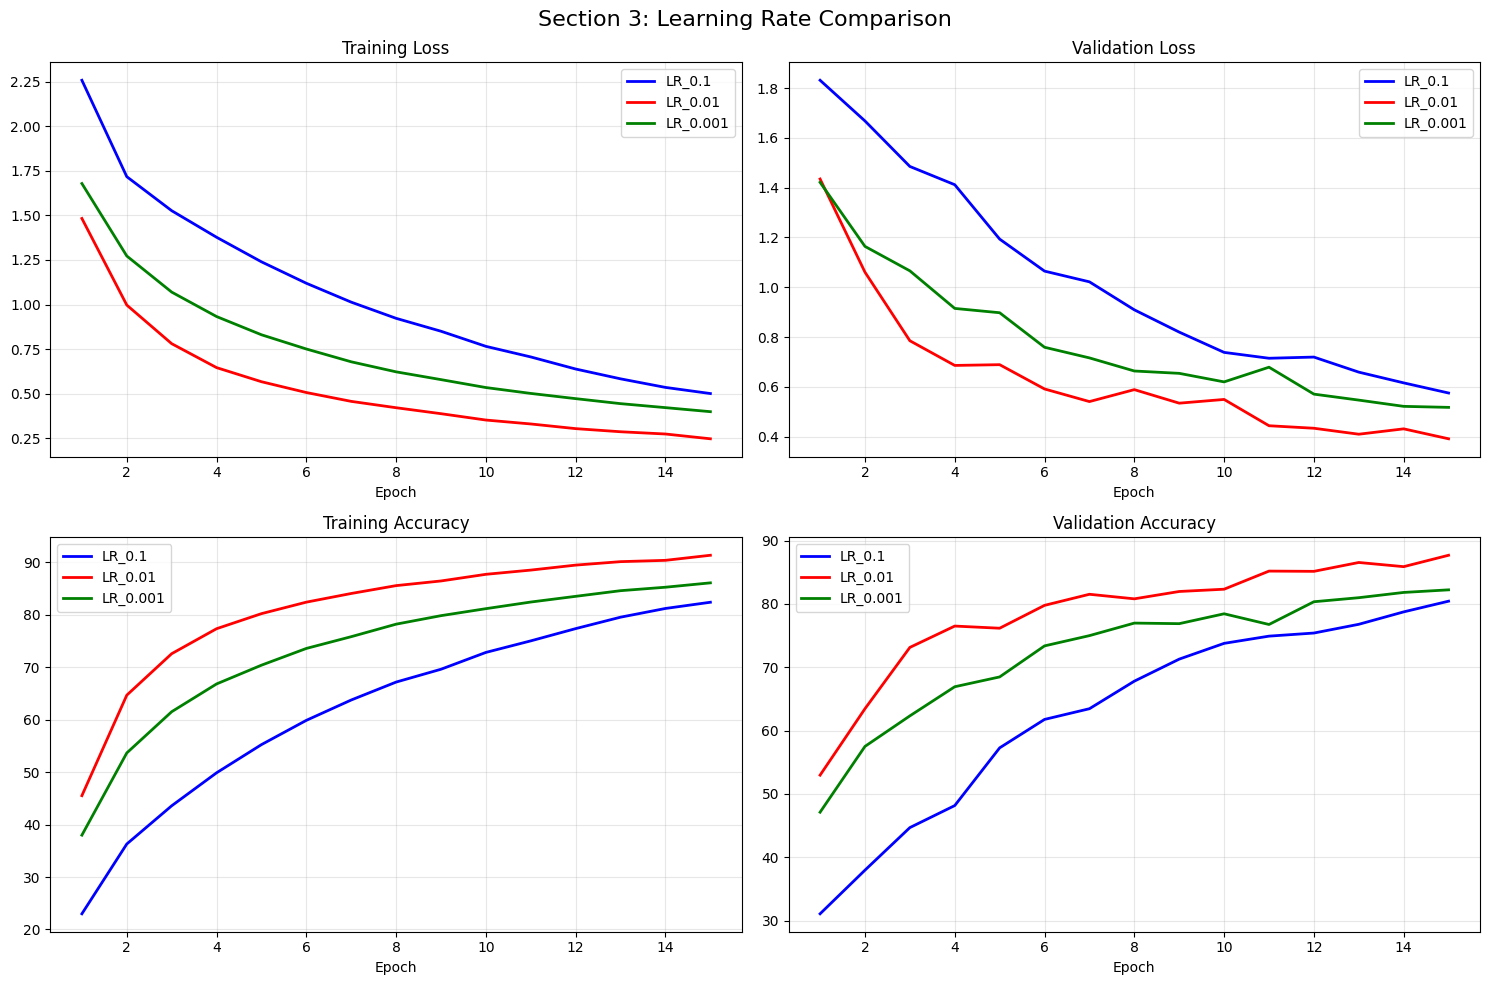


Best Learning Rate: 0.01

SECTION 4: LEARNING RATE SCHEDULING

--- Testing Scheduler: Constant_LR ---


Epoch 50: LR: 0.010000, Train Acc: 98.44%, Val Acc: 90.17%


Epoch 100: LR: 0.010000, Train Acc: 99.71%, Val Acc: 91.45%


Epoch 150: LR: 0.010000, Train Acc: 99.92%, Val Acc: 91.60%


Epoch 200: LR: 0.010000, Train Acc: 99.97%, Val Acc: 92.28%


Epoch 250: LR: 0.010000, Train Acc: 99.95%, Val Acc: 92.01%


Epoch 300: LR: 0.010000, Train Acc: 99.97%, Val Acc: 92.65%
Final - Constant_LR: Train Acc: 99.97%, Val Acc: 92.65%

--- Testing Scheduler: CosineAnnealing ---


Epoch 50: LR: 0.009330, Train Acc: 98.78%, Val Acc: 89.79%


Epoch 100: LR: 0.007500, Train Acc: 99.87%, Val Acc: 91.83%


Epoch 150: LR: 0.005000, Train Acc: 99.99%, Val Acc: 92.87%


Epoch 200: LR: 0.002500, Train Acc: 100.00%, Val Acc: 92.98%


Epoch 250: LR: 0.000670, Train Acc: 100.00%, Val Acc: 93.09%


Epoch 300: LR: 0.000000, Train Acc: 100.00%, Val Acc: 92.94%
Final - CosineAnnealing: Train Acc: 100.00%, Val Acc: 92.94%


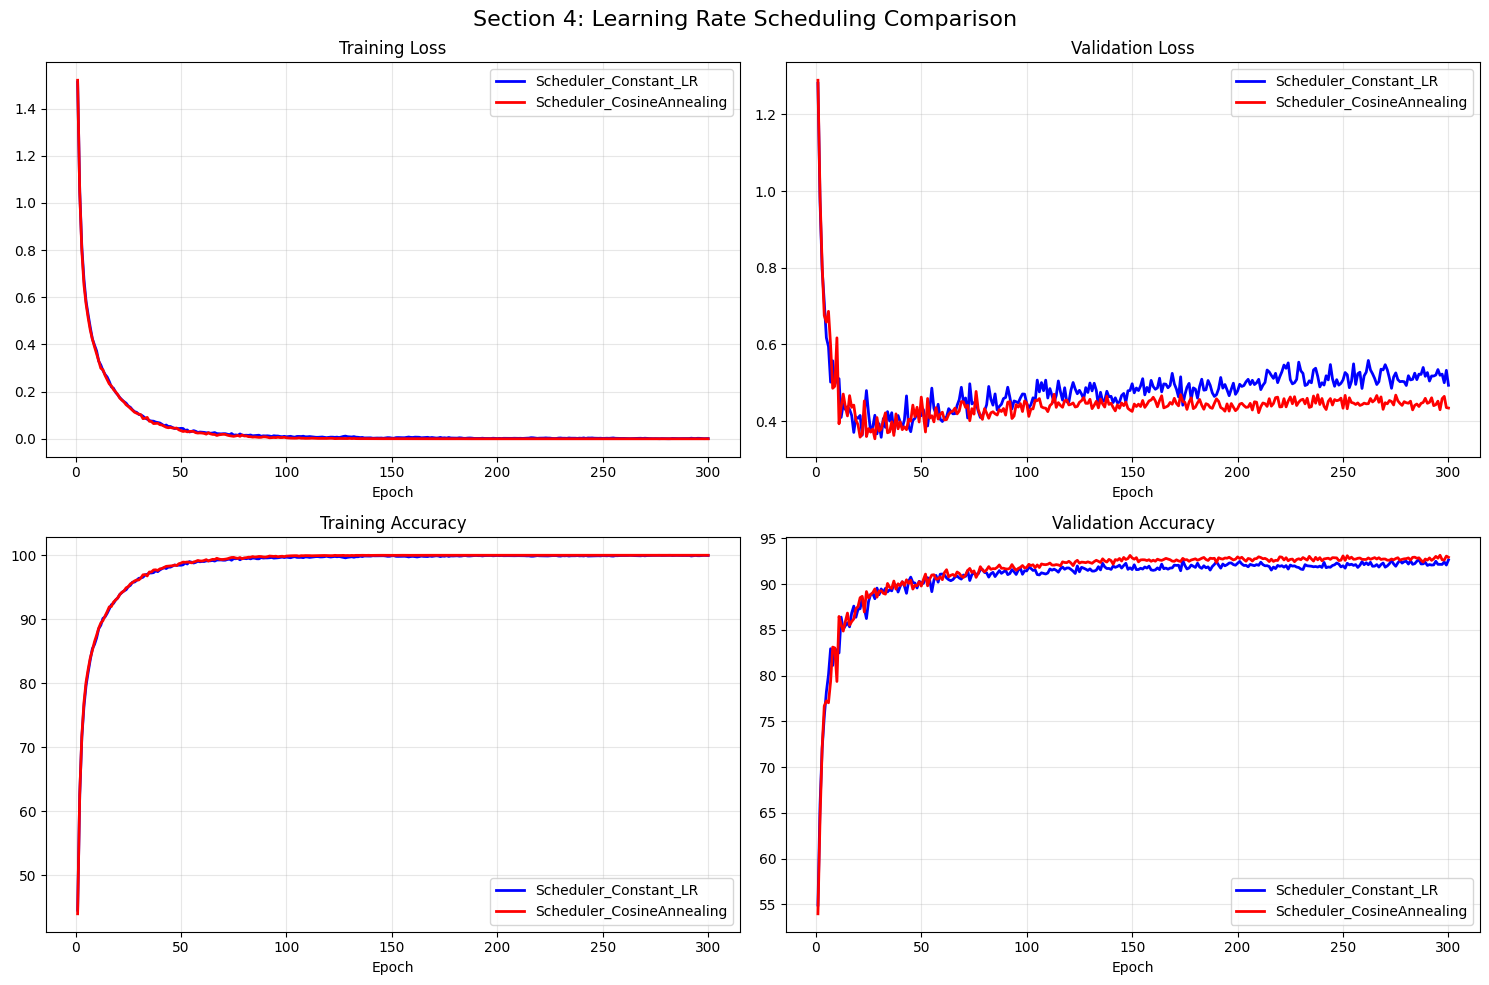


SECTION 5: WEIGHT DECAY EXPERIMENTS

--- Testing Weight Decay: 0.0005 ---


Epoch 50: Train Acc: 97.90%, Val Acc: 89.44%


Epoch 100: Train Acc: 98.92%, Val Acc: 90.68%


Epoch 150: Train Acc: 99.47%, Val Acc: 91.54%


Epoch 200: Train Acc: 100.00%, Val Acc: 93.37%


Epoch 250: Train Acc: 100.00%, Val Acc: 93.55%


Epoch 300: Train Acc: 100.00%, Val Acc: 93.78%
Final - WD 0.0005: Train Acc: 100.00%, Val Acc: 93.78%

--- Testing Weight Decay: 0.01 ---


Epoch 50: Train Acc: 85.30%, Val Acc: 69.06%


Epoch 100: Train Acc: 87.31%, Val Acc: 75.50%


Epoch 150: Train Acc: 90.39%, Val Acc: 80.33%


Epoch 200: Train Acc: 94.55%, Val Acc: 84.83%


Epoch 250: Train Acc: 99.21%, Val Acc: 92.93%


Epoch 300: Train Acc: 100.00%, Val Acc: 94.59%
Final - WD 0.01: Train Acc: 100.00%, Val Acc: 94.59%


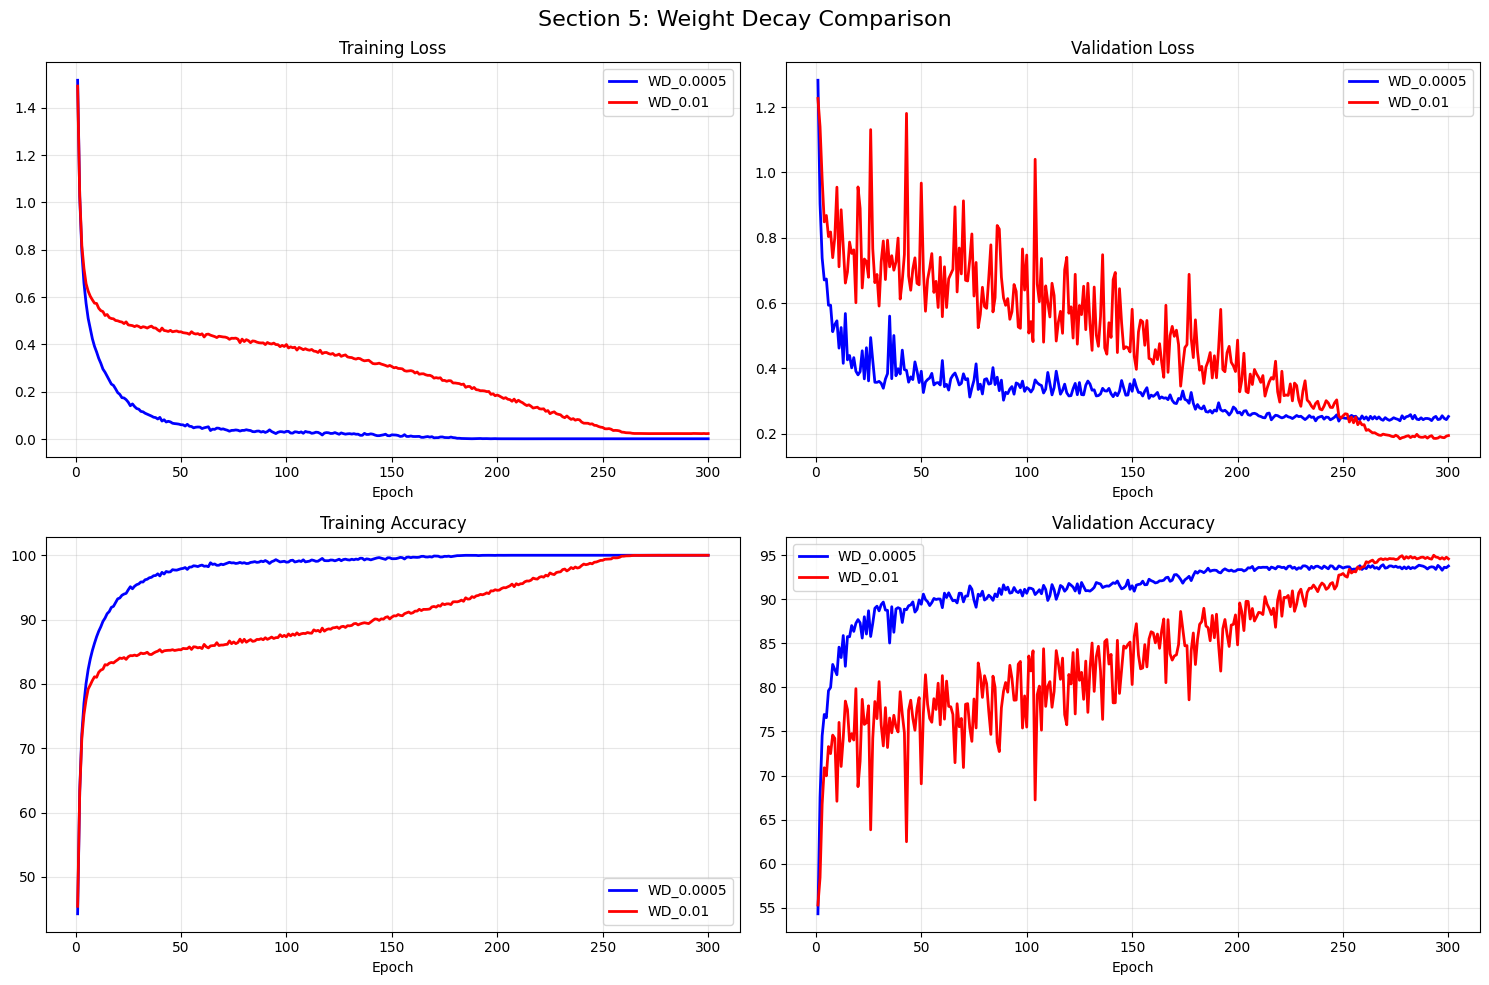


Best Weight Decay: 0.01

SECTION 6: CUSTOM BATCH NORMALIZATION

--- Testing: Standard_BN ---


Epoch 50: Train Acc: 85.71%, Val Acc: 74.18%


Epoch 100: Train Acc: 87.27%, Val Acc: 72.28%


Epoch 150: Train Acc: 90.47%, Val Acc: 82.53%


Epoch 200: Train Acc: 94.50%, Val Acc: 85.99%


Epoch 250: Train Acc: 99.19%, Val Acc: 91.96%


Epoch 300: Train Acc: 100.00%, Val Acc: 94.79%
Final - Standard_BN: Train Acc: 100.00%, Val Acc: 94.79%

--- Testing: Custom_BN ---


Epoch 50: Train Acc: 26.18%, Val Acc: 16.48%


Epoch 100: Train Acc: 26.62%, Val Acc: 21.90%


Epoch 150: Train Acc: 27.05%, Val Acc: 26.27%


Epoch 200: Train Acc: 26.99%, Val Acc: 18.35%


Epoch 250: Train Acc: 27.28%, Val Acc: 26.49%


Epoch 300: Train Acc: 26.95%, Val Acc: 27.60%
Final - Custom_BN: Train Acc: 26.95%, Val Acc: 27.60%


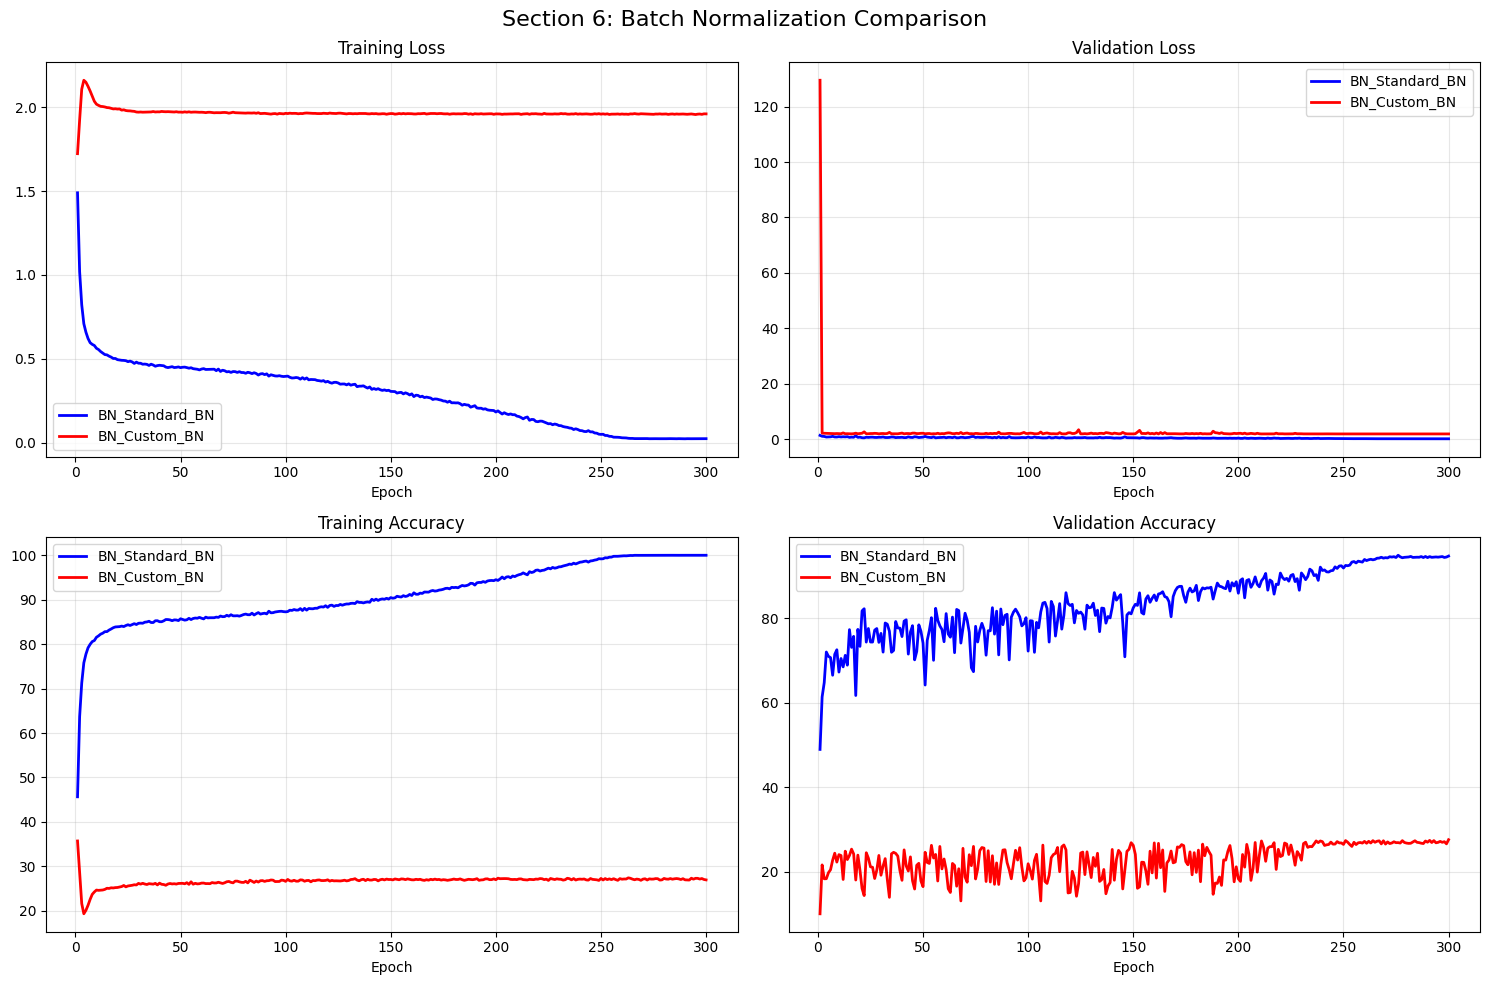


Best BatchNorm: Standard_BN

FINAL TEST EVALUATION

Best Configuration:
Learning Rate: 0.01
Scheduler: CosineAnnealing
Weight Decay: 0.01
BatchNorm: Standard_BN

Training final model for 300 epochs...


Epoch 50: LR: 0.009330, Train Acc: 85.37%, Val Acc: 77.96%


Epoch 100: LR: 0.007500, Train Acc: 87.41%, Val Acc: 79.92%


Epoch 150: LR: 0.005000, Train Acc: 90.44%, Val Acc: 80.80%


Epoch 200: LR: 0.002500, Train Acc: 94.68%, Val Acc: 88.40%


Epoch 250: LR: 0.000670, Train Acc: 99.11%, Val Acc: 91.74%


Epoch 300: LR: 0.000000, Train Acc: 99.99%, Val Acc: 94.63%

Final Test Evaluation:


Test Accuracy: 95.04%

All experiments completed successfully!
32600.646599292755


In [5]:
import time
tic = time.time()
# ===========================
# Main experiments
# ===========================
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Section 3: Learning Rate Experiments
    print("=" * 60)
    print("SECTION 3: LEARNING RATE EXPERIMENTS")
    print("=" * 60)

    learning_rates = [0.1, 0.01, 0.001]
    lr_results = {}

    for lr in learning_rates:
        print(f"\n--- Testing Learning Rate: {lr} ---")
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0)

        experiment_name = f'LR_{lr}'

        for epoch in range(1, 16):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, None, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)
            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        lr_results[lr] = final_result
        print(f"Final - LR {lr}: Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['LR_0.1', 'LR_0.01', 'LR_0.001'],
                           "Section 3: Learning Rate Comparison")

    best_lr = max(lr_results.keys(), key=lambda x: lr_results[x]['val_acc'])
    print(f"\nBest Learning Rate: {best_lr}")

    # Section 4: Learning Rate Schedule
    print("\n" + "=" * 60)
    print("SECTION 4: LEARNING RATE SCHEDULING")
    print("=" * 60)

    # Constant LR vs Cosine Annealing
    schedulers = {
        'Constant_LR': None,
        'CosineAnnealing': optim.lr_scheduler.CosineAnnealingLR
    }

    scheduler_results = {}

    for sched_name in schedulers.keys():
        print(f"\n--- Testing Scheduler: {sched_name} ---")
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0)

        if sched_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
        else:
            scheduler = None

        experiment_name = f'Scheduler_{sched_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        scheduler_results[sched_name] = final_result
        print(f"Final - {sched_name}: Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['Scheduler_Constant_LR', 'Scheduler_CosineAnnealing'],
                           "Section 4: Learning Rate Scheduling Comparison")

    # Section 5: Weight Decay
    print("\n" + "=" * 60)
    print("SECTION 5: WEIGHT DECAY EXPERIMENTS")
    print("=" * 60)

    weight_decays = [5e-4, 1e-2]
    wd_results = {}

    for wd in weight_decays:
        print(f"\n--- Testing Weight Decay: {wd} ---")
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'WD_{wd}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        wd_results[wd] = final_result
        print(f"Final - WD {wd}: Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['WD_0.0005', 'WD_0.01'],
                           "Section 5: Weight Decay Comparison")

    best_wd = max(wd_results.keys(), key=lambda x: wd_results[x]['val_acc'])
    print(f"\nBest Weight Decay: {best_wd}")

    # Section 6: Custom Batch Normalization
    print("\n" + "=" * 60)
    print("SECTION 6: CUSTOM BATCH NORMALIZATION")
    print("=" * 60)

    bn_types = [
        ('Standard_BN', False),
        ('Custom_BN', True)
    ]

    bn_results = {}

    for bn_name, use_custom in bn_types:
        print(f"\n--- Testing: {bn_name} ---")
        net = ResNet18(use_custom_bn=use_custom).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'BN_{bn_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        bn_results[bn_name] = final_result
        print(f"Final - {bn_name}: Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['BN_Standard_BN', 'BN_Custom_BN'],
                           "Section 6: Batch Normalization Comparison")

    best_bn = max(bn_results.keys(), key=lambda x: bn_results[x]['val_acc'])
    print(f"\nBest BatchNorm: {best_bn}")

    # Final Test Evaluation
    print("\n" + "=" * 60)
    print("FINAL TEST EVALUATION")
    print("=" * 60)

    print(f"\nBest Configuration:")
    print(f"Learning Rate: {best_lr}")
    print(f"Scheduler: CosineAnnealing")
    print(f"Weight Decay: {best_wd}")
    print(f"BatchNorm: {best_bn}")

    # Train final model with best configuration
    use_custom_bn = (best_bn == 'BN_Custom_BN')
    final_net = ResNet18(use_custom_bn=use_custom_bn).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(final_net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

    print(f"\nTraining final model for 300 epochs...")
    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, 301):
        train_loss, train_acc = train(epoch, final_net, criterion, trainloader, scheduler, optimizer)
        val_loss, val_acc = validate(epoch, final_net, criterion, valloader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = final_net.state_dict().copy()

        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Acc: {val_acc:.2f}%")

    # Load best model and evaluate on test set
    final_net.load_state_dict(best_model_state)

    print("\nFinal Test Evaluation:")
    test_loss, test_acc = validate(0, final_net, criterion, testloader)
    print(f"Test Accuracy: {test_acc:.2f}%")

    print("\nAll experiments completed successfully!")

print(time.time() - tic)